In [1]:
%matplotlib notebook

import json_lines
from collections import defaultdict

import jieba
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import datetime
import numpy as np
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

font = font_manager.FontProperties(fname='msjh.ttc', size=14)
sns.set(style='whitegrid')

In [2]:
# load ptt posts

path = 'output\Gossiping-2000.json'
target_day = datetime.date(2017, 6, 2)

# with open(path, 'rb') as f:
#     for post in json_lines.reader(f):
#         print(post['title'])

# Title Analysis

In [3]:
# get title

total_title = defaultdict(int)

with open(path, 'rb') as f:
    total_post_number = 0
    for post in json_lines.reader(f):
        post_date_str = post['date']
        post_date = datetime.datetime.strptime(post_date_str, '%Y-%m-%d %H:%M:%S')
         
        if (post_date.date() == target_day):
            title = post['title']
            total_title[title] += 1
            total_post_number = total_post_number + 1
    print(total_post_number)

2791


In [4]:
def show_distributions(counts):
    sorted_cnts = [t[0] for t in sorted(counts.items(), key=lambda x: -x[1])][:10]
    y = [counts[u] for u in sorted_cnts]

    x = range(len(y))
    top_names = [x for x in sorted_cnts]
    
#     f, ax = plt.subplots(figsize=(10, 10))
    
#     sns.set_color_codes('pastel')
#     sns.plt.plot(x, y, label='Total {}'.format('comments'), color='blue')
    
#     ax.legend(ncol=3, loc='upper right', frameon=True)
#     ax.set(ylabel='counts',
#            xlabel='',
#            title='Total comments')
#     ax.set_xticklabels(top_names, rotation=90, fontproperties=font)
#     sns.despine(left=True, bottom=True)

#     plt.show(f)
    
    for user in top_names:
        print(user)
    for i in y:
        print(i)

In [5]:
# display pushes
show_distributions(total_title)

Re: [新聞] 黃國昌勘災不撐傘全身濕透 網友：不當總
Re: [新聞] 陸客硬拗提早入住　還嗆台灣民宿：敢汙辱
Re: [問卦] 北科大真的不如中原、元智嗎?
Re: [ＦＢ] 張君玟 請搞懂父權紅利的意義
Re: [ＦＢ] 驚!柯文哲選前公宅5萬戶 選後3453戶
Re: [問卦] 中國跟日本   哪個讓你有親近感？
Re: [新聞] 川普宣布美國退出巴黎氣候協定
Re: [新聞] 美退出巴黎氣候協定 馬斯克宣布不再任川
Re: [問卦] 0610反空污大遊行，反核在幹嘛？
Re: [爆卦]  阿聯酋名牌事件後續
18
16
13
13
12
11
11
9
8
7


# Word Analysis

In [6]:
# grap post
words = []
scores = []
jieba.set_dictionary('dict.txt.big')
with open(path, 'rb') as f:
    for post in json_lines.reader(f):
        post_date_str = post['date']
        post_date = datetime.datetime.strptime(post_date_str, '%Y-%m-%d %H:%M:%S')
         
        if (post_date.date() == target_day):
#             print (post_date)
            d = defaultdict(int)

            content = post['content']
            if post['score'] != 0:
                for l in content.split('\n'):
                    if l:
                        for w in jieba.cut(l):
                            d[w] += 1
                if len(d) > 0:
                    words.append(d)
                    scores.append(1 if post['score'] > 0 else 0)

Building prefix dict from C:\Users\蔡奇宏\Desktop\scrapy\dict.txt.big ...
Loading model from cache C:\Users\蔡奇宏\AppData\Local\Temp\jieba.u448f780059d72ef892e16ade52b4cd8a.cache
Loading model cost 1.216 seconds.
Prefix dict has been built succesfully.


In [7]:
# grap comments
c_words = []
c_scores = []

with open(path, 'rb') as f:
    for post in json_lines.reader(f):
        
        post_date_str = post['date']
        post_date = datetime.datetime.strptime(post_date_str, '%Y-%m-%d %H:%M:%S')
        
        if (post_date.date() == target_day):
            for comment in post['comments']:
                l = comment['content'].strip()
                if l and comment['score'] != 0:
                    d = defaultdict(int)
                    for w in jieba.cut(l):
                        d[w] += 1
                    if len(d) > 0:
                        c_scores.append(1 if comment['score'] > 0 else 0)
                        c_words.append(d)

In [8]:
# convert to vectors
dvec = DictVectorizer()
tfidf = TfidfTransformer()
X = tfidf.fit_transform(dvec.fit_transform(words))

c_dvec = DictVectorizer()
c_tfidf = TfidfTransformer()
c_X = c_tfidf.fit_transform(c_dvec.fit_transform(c_words))

In [9]:
svc = LinearSVC()
svc.fit(X, scores)

c_svc = LinearSVC()
c_svc.fit(c_X, c_scores)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [10]:
def display_top_features(weights, names, top_n, select=abs):
    
    
    top_features = sorted(zip(weights, names), key=lambda x: select(x[0]), reverse=True)[:top_n]
    top_weights = [x[0] for x in top_features]
    top_names = [x[1] for x in top_features]

    fig, ax = plt.subplots(figsize=(10,8))
    ind = np.arange(top_n)
    bars = ax.bar(ind, top_weights, color='blue', edgecolor='black')
    for bar, w in zip(bars, top_weights):
        if w < 0:
            bar.set_facecolor('red')
   
    width = 0.30
    ax.set_xticks(ind + width)
    ax.set_xticklabels(top_names, rotation=90, fontproperties=font)

    plt.show(fig)
    
    for word in top_names:
        print (word)

<IPython.core.display.Javascript object>


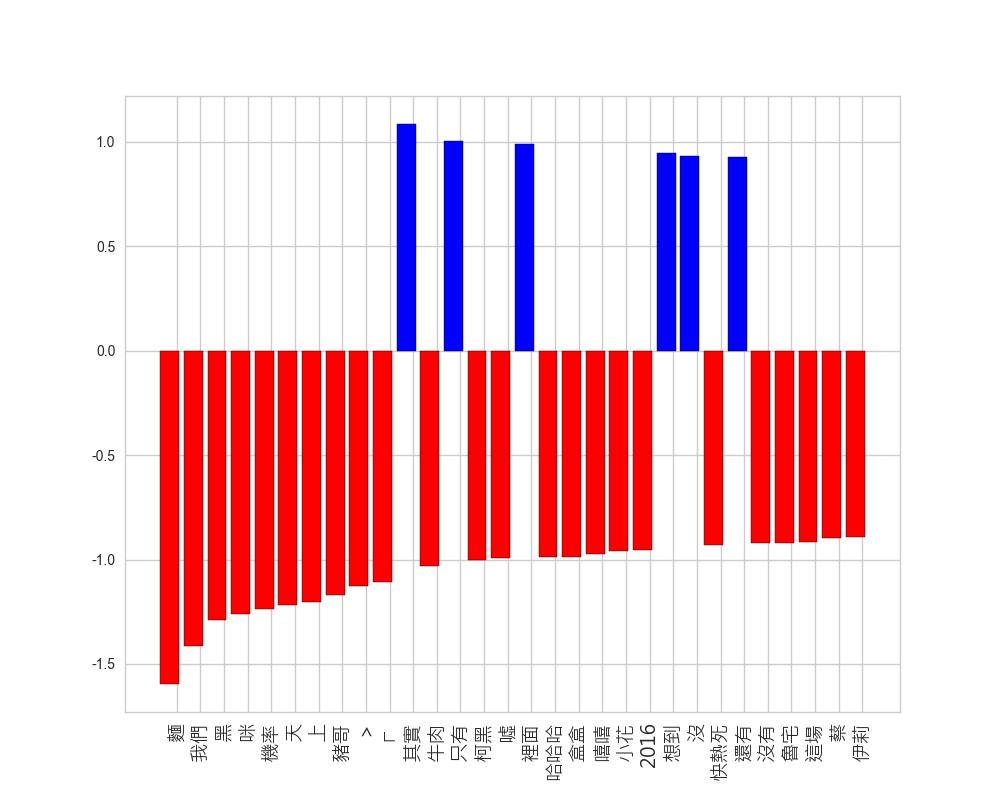

麵
我們
黑
咪
機率
天
上
豬哥
>
ㄇ
其實
牛肉
只有
柯黑
噓
裡面
哈哈哈
盒盒
嘻嘻
小花
2016
想到
沒
快熱死
還有
沒有
魯宅
這場
蔡
伊莉


In [11]:
# top features for posts
display_top_features(svc.coef_[0], dvec.get_feature_names(), 30)

<IPython.core.display.Javascript object>


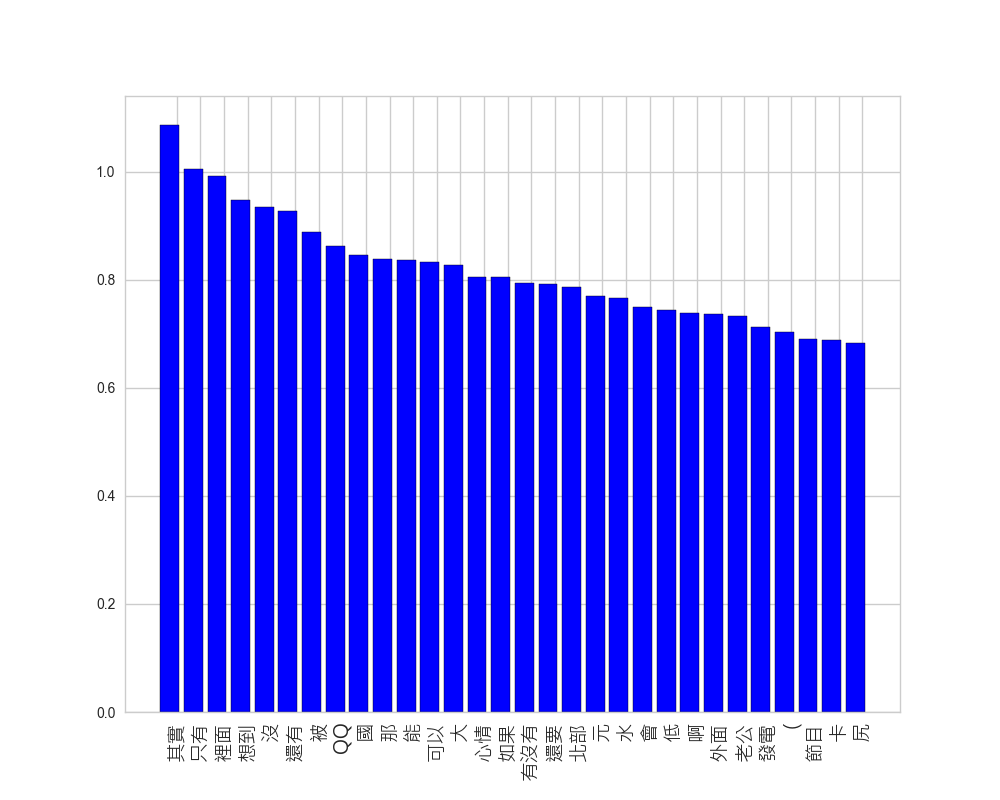

其實
只有
裡面
想到
沒
還有
被
QQ
國
那
能
可以
大
心情
如果
有沒有
還要
北部
元
水
會
低
啊
外面
老公
發電
(
節目
卡
尻


In [12]:
# top positive features for posts
display_top_features(svc.coef_[0], dvec.get_feature_names(), 30, select=lambda x: x)

<IPython.core.display.Javascript object>


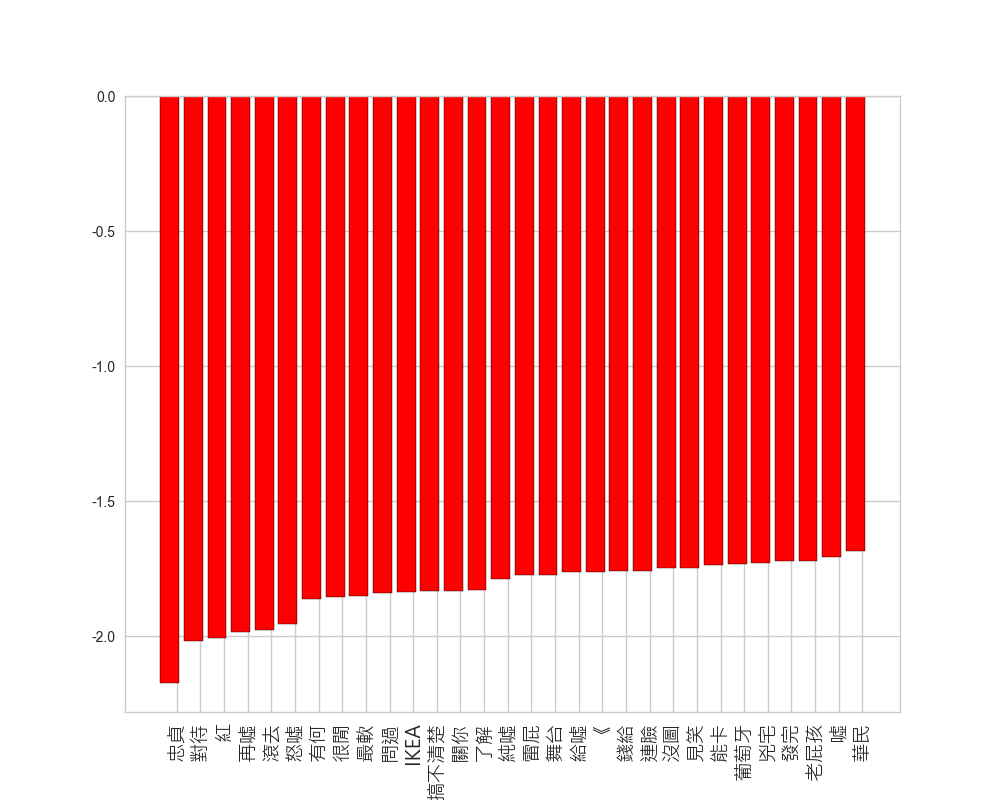

忠貞
對待
紅
再噓
滾去
怒噓
有何
很閒
最軟
問過
IKEA
搞不清楚
關你
了解
純噓
雷屁
舞台
給噓
《
錢給
連臉
沒圖
見笑
能卡
葡萄牙
兇宅
發完
老屁孩
噓
華民


In [13]:
# top features for comments
display_top_features(c_svc.coef_[0], c_dvec.get_feature_names(), 30)

<IPython.core.display.Javascript object>


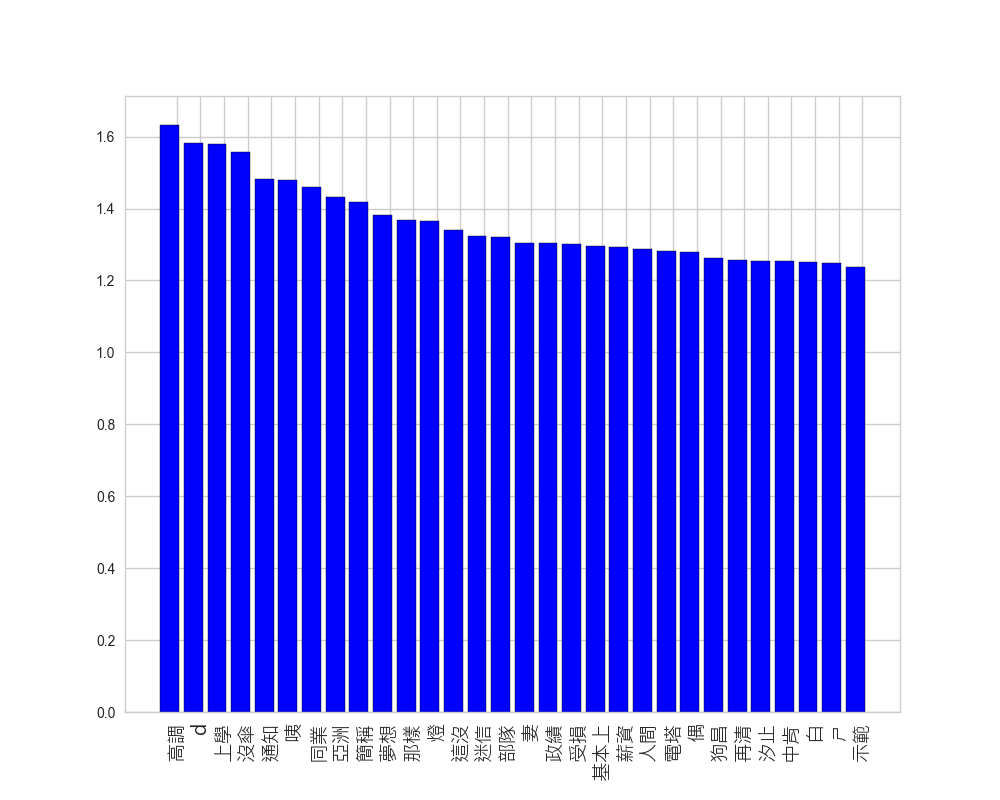

高調
d
上學
沒傘
通知
咦
同業
亞洲
簡稱
夢想
那樣
燈
這沒
迷信
部隊
妻
政績
受損
基本上
薪資
人間
電塔
偶
狗昌
再清
汐止
中肯
白
ㄕ
示範


In [14]:
# top positive features for comments
display_top_features(c_svc.coef_[0], c_dvec.get_feature_names(), 30, select=lambda x: x)